# KickIT 



In [2]:
# Importing the dataFrame libraries
# to save the model
import pickle
import numpy as np
import pandas as pd
#Importing the visualization libraries 
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
#For feature scaling  standardScaler module.
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


# Reading the Data

In [3]:
# Downlaoding the data from the source writing and saved it as a Raw dataframe 
df_raw = pd.read_csv('https://www.openml.org/data/get_csv/19335679/kick.arff')

In [4]:
# Copy the raw file for  the preprocessing step, because the download take some time 
df_prep = df_raw.copy()

In [5]:
#Printing the dataframe
df_prep.head(5)

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,0,1260144000,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,...,11597,12409,?,?,21973,33619,FL,7100,0,1113
1,0,1260144000,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,...,11374,12791,?,?,19638,33619,FL,7600,0,1053
2,0,1260144000,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,...,7146,8702,?,?,19638,33619,FL,4900,0,1389
3,0,1260144000,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,...,4375,5518,?,?,19638,33619,FL,4100,0,630
4,0,1260144000,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,...,6739,7911,?,?,19638,33619,FL,4000,0,1020


In [6]:
# Seing information about the dataframe schema
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   IsBadBuy                           72983 non-null  int64 
 1   PurchDate                          72983 non-null  int64 
 2   Auction                            72983 non-null  object
 3   VehYear                            72983 non-null  int64 
 4   VehicleAge                         72983 non-null  int64 
 5   Make                               72983 non-null  object
 6   Model                              72983 non-null  object
 7   Trim                               72983 non-null  object
 8   SubModel                           72983 non-null  object
 9   Color                              72983 non-null  object
 10  Transmission                       72983 non-null  object
 11  WheelTypeID                        72983 non-null  object
 12  Whee

# Preprocessing the Data

# Dealing with missing values

### Checking  null values

In [7]:
# Checking for null values 
df_prep.isnull().sum().sum()

0

In [8]:
# printing a message 
print(f"The dataframe has {df_prep.shape[0]} , and there seems to be {df_prep.isnull().sum().sum()} null values \n")

The dataframe has 72983 , and there seems to be 0 null values 



When looking closely to the dataset '?' seems to replace null values. We have to revert this In order to see the real states of null values in this data

### Replacing the  '?'   by Null and counting again the nulls values.

In [9]:
df_prep= df_prep.replace(['?'], np.nan )
# Saving the count  null values for future call
null_count = df_prep.isnull().sum().sum()
print(f" after replacing '?' by null  there is  {null_count} null values \n")

 after replacing '?' by null  there is  149271 null values 



### Laying down the strategy  With this large  number of nulls

The objective is to keep as many sample as we can by optimizing the lost by missing value: Scan by column and dropping columns that has missing value that passed a preset threshold (here more than 10% of the entire column). Also choosing column that are not relevant to the scope of this project.
Finally we will scan also per threshold for the row contents that have not enough filled informations.
  

 

In [10]:
# find  features column a  that has more than 10 percent of Null the values 
# creating an empty list that will receive the found columns 
findings =[]
for col in df_prep.columns:
    ratio = int(100*((df_prep[col].isna().sum())/df_prep.shape[0]))
    if ratio > 10:
        findings.append(col)
        print(f" the column {col} has {ratio} % of Null values")
    else : 
        pass
print(f" We will drop{findings} as they have no enough filled informations")

 the column PRIMEUNIT has 95 % of Null values
 the column AUCGUART has 95 % of Null values
 We will drop['PRIMEUNIT', 'AUCGUART'] as they have no enough filled informations


In [11]:
# Making a list of columns to drop
drop_list = ['PurchDate','VehYear','WheelTypeID','BYRNO','VNZIP1','VehBCost']
# adding our findings per columns
drop_list += findings
print(f"here is the list of columns to be dropped {drop_list}")


here is the list of columns to be dropped ['PurchDate', 'VehYear', 'WheelTypeID', 'BYRNO', 'VNZIP1', 'VehBCost', 'PRIMEUNIT', 'AUCGUART']


In [12]:
# let's drop the identified columns 
df_prep = df_prep.drop(drop_list, axis = 1)
# let's save sample size  after this proccess for later call
sample_size_after_col_drop = df_prep.shape[0]

In [13]:
# Let's verify how much null values we have and for how much we reduced it 
null_after_columns_dropped = df_prep.isnull().sum().sum()
reduction_in_null_values = null_count - null_after_columns_dropped
print(f" We went from {null_count} null values to {null_after_columns_dropped} \n \
We have reduced the missing values by {reduction_in_null_values} \
(equivalent to {(int(100* (reduction_in_null_values/null_count)))} % ) \
of  missing values \n just by dropping the unnecessary columns.\n \
The sample size remains {sample_size_after_col_drop}")

 We went from 149271 null values to 6906 
 We have reduced the missing values by 142365 (equivalent to 95 % ) of  missing values 
 just by dropping the unnecessary columns.
 The sample size remains 72983


Let's do the same "scan & drop" by row 

In [14]:
# find  sample that has more than 10 percent of Null the values in their column line 

row_list =[]
# for every sample in the sample size
for datum in range(df_prep.shape[0]):
  # find the sum of null value in the row
  row_ratio = df_prep.iloc[[datum]].isna().sum().sum()
  # calculates the percentage of missing values regarding the number of features
  ratio = 100*(row_ratio)/df_prep.shape[1]
  # When this percentage exceed 10 % 
  if ratio > 10:
        # Add this row index to row_list
        row_list.append(datum)
else : 
        pass

# print the count of sample to be removed 
print(f"{len(row_list)} sample that don't follow the rule  have to be removed" )

324 sample that don't follow the rule  have to be removed


In [15]:
# Saving the count of sample before removal
nbr_sample = df_prep.shape[0]
# removing the samples that don't follow the rule
df_prep = df_prep.drop(index=row_list,axis= 0)
# counting the number of rows after removing the sample
nbr_sample_after_removal = df_prep.shape[0]

In [16]:
df_prep.index = range(len(df_prep.index))

In [17]:
null_after_row_drop = df_prep.isnull().sum().sum()

In [18]:
print(f"We went from {null_after_columns_dropped}  null values to {null_after_row_drop } \n \
We have reduced the missing values by {null_after_columns_dropped - null_after_row_drop}. \
Total reduction of null is {null_after_columns_dropped - null_after_row_drop +reduction_in_null_values } \
(equivalent to \
 {(int(100* ((null_after_columns_dropped - null_after_row_drop +reduction_in_null_values )/null_count)))} % ) \
of  missing values \n just by dropping the unnecessary columnsand rows.\n \
The sample size  is {nbr_sample_after_removal}, it was {nbr_sample}" )

We went from 6906  null values to 5522 
 We have reduced the missing values by 1384. Total reduction of null is 143749 (equivalent to  96 % ) of  missing values 
 just by dropping the unnecessary columnsand rows.
 The sample size  is 72659, it was 72983


In [19]:
# let's  see how many sample are now affected by null values
temp_df = df_prep[df_prep.isnull().any(axis = 1)]
# how many kicks  do we have in those missing values
kicks_in_null = temp_df['IsBadBuy'].sum()
# how many kicks do we have in the total dataset
kicks_in_dataframe = df_prep['IsBadBuy'].sum()

print(f" The dataframe has {nbr_sample_after_removal} sample and  we have  {kicks_in_dataframe} kicks in  total in the present dataframe. \n \
we have {kicks_in_null} kicks in the null that are in the  present dataframe. \n \
If I delete the nulls rows I  will loose {int(100*(kicks_in_null/kicks_in_dataframe))} %  of kick  labeled sample ")


 The dataframe has 72659 sample and  we have  8943 kicks in  total in the present dataframe. 
 we have 2510 kicks in the null that are in the  present dataframe. 
 If I delete the nulls rows I  will loose 28 %  of kick  labeled sample 


The data is clearly unbalanced. As I will have to decide on how to deal with that, in advance,  instead of droping the nulls, I decide to go for imputing stragie at this stage  and downsample at a later stage . 

### Imputing value to null rows
 let's see which column is affected by the nulls values 

In [20]:
df_prep.isnull().sum()

IsBadBuy                                0
Auction                                 0
VehicleAge                              0
Make                                    0
Model                                   0
Trim                                 2357
SubModel                                0
Color                                   0
Transmission                            1
WheelType                            3164
VehOdo                                  0
Nationality                             0
Size                                    0
TopThreeAmericanName                    0
MMRAcquisitionAuctionAveragePrice       0
MMRAcquisitionAuctionCleanPrice         0
MMRAcquisitionRetailAveragePrice        0
MMRAcquisitonRetailCleanPrice           0
MMRCurrentAuctionAveragePrice           0
MMRCurrentAuctionCleanPrice             0
MMRCurrentRetailAveragePrice            0
MMRCurrentRetailCleanPrice              0
VNST                                    0
IsOnlineSale                      

In [21]:
# let's filter thoses columns
null_counts = df_prep.isnull().sum()
null_counts[null_counts > 0]

Trim            2357
Transmission       1
WheelType       3164
dtype: int64

In [22]:
# let's see thoses columns
df_prep[['Trim','Transmission','WheelType']].head(10)

,Trim,Transmission,WheelType
0,i,AUTO,Alloy
1,ST,AUTO,Alloy
2,SXT,AUTO,Covers
3,SXT,AUTO,Alloy
4,ZX3,MANUAL,Covers
5,ES,AUTO,Covers
6,EX,AUTO,Covers
7,SE,AUTO,Covers
8,EX,AUTO,Covers
9,SEL,AUTO,Alloy


The imputing strategy here would be to set the nulls for 'Trim','Transmission','WheelType' to their mode ( most frequent input of the coulumn). . 

In [23]:
# let's do it for the categorical variables list
# seting the list of column
catList = ['Trim','Transmission','WheelType']
# looping for the imputing strategy for each column
for cat in catList:
    # replace each null value by the most frequent value
    df_prep[cat]= df_prep[cat].replace( np.nan, df_prep[cat].mode )


In [24]:
#Checking the indexation
df_prep.index

RangeIndex(start=0, stop=72659, step=1)

In [25]:
# final_check
df_prep.isnull().sum()


IsBadBuy                             0
Auction                              0
VehicleAge                           0
Make                                 0
Model                                0
Trim                                 0
SubModel                             0
Color                                0
Transmission                         0
WheelType                            0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitonRetailCleanPrice        0
MMRCurrentAuctionAveragePrice        0
MMRCurrentAuctionCleanPrice          0
MMRCurrentRetailAveragePrice         0
MMRCurrentRetailCleanPrice           0
VNST                                 0
IsOnlineSale                         0
WarrantyCost                         0
dtype: int64

# Balancing the dataset

In [26]:
# Count how many targets are 1 (meaning that the car is a kick)
num_one_targets = df_prep['IsBadBuy'].sum()
# Set a counter for targets that are 0 (meaning that the customer did not convert)
zero_targets_counter = 0
row_list2 =[]
# We want to create a "balanced" dataset, so we will have to remove some input/target pairs

for i in df_prep.index.astype('int64'):
    if (df_prep.loc[i,'IsBadBuy']) == 0:
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            row_list2.append(i)
df_prep = df_prep.drop(index=row_list2,axis= 0)
#resetting the index
df_prep.index = range(len(df_prep.index))

In [27]:
# Setting the the new name of the balanced dataset
df_prep_balanced = df_prep

## Dealing with data types

In [28]:
df_prep_balanced.index 

RangeIndex(start=0, stop=17886, step=1)

In [29]:
df_prep_balanced.dtypes

IsBadBuy                              int64
Auction                              object
VehicleAge                            int64
Make                                 object
Model                                object
Trim                                 object
SubModel                             object
Color                                object
Transmission                         object
WheelType                            object
VehOdo                                int64
Nationality                          object
Size                                 object
TopThreeAmericanName                 object
MMRAcquisitionAuctionAveragePrice    object
MMRAcquisitionAuctionCleanPrice      object
MMRAcquisitionRetailAveragePrice     object
MMRAcquisitonRetailCleanPrice        object
MMRCurrentAuctionAveragePrice        object
MMRCurrentAuctionCleanPrice          object
MMRCurrentRetailAveragePrice         object
MMRCurrentRetailCleanPrice           object
VNST                            

In [30]:
# converting the categorical columns to string 
catCols =['Auction','Make','Model', 'Trim','SubModel','Color','Transmission','Nationality','Size','TopThreeAmericanName','VNST']
for col in catCols:
      df_prep_balanced[col] = df_prep_balanced[col].astype(str)
# converting to double the list of double type compatible coulumns
num_double = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice','WarrantyCost']
for col in num_double:
     df_prep_balanced[col] = df_prep_balanced[col].astype('int64')
     


In [31]:
df_prep.dtypes

IsBadBuy                              int64
Auction                              object
VehicleAge                            int64
Make                                 object
Model                                object
Trim                                 object
SubModel                             object
Color                                object
Transmission                         object
WheelType                            object
VehOdo                                int64
Nationality                          object
Size                                 object
TopThreeAmericanName                 object
MMRAcquisitionAuctionAveragePrice     int64
MMRAcquisitionAuctionCleanPrice       int64
MMRAcquisitionRetailAveragePrice      int64
MMRAcquisitonRetailCleanPrice         int64
MMRCurrentAuctionAveragePrice         int64
MMRCurrentAuctionCleanPrice           int64
MMRCurrentRetailAveragePrice          int64
MMRCurrentRetailCleanPrice            int64
VNST                            

# Dealing with the categorical variable

In [32]:
# let's have a look at how many labels
catCols =['Auction','Make','Model', 'Trim','SubModel','Color','Transmission','Nationality','Size','TopThreeAmericanName','VNST']

for col in df_prep_balanced[catCols]:
              print(col, ': ', len(df_prep_balanced[col].unique()),'labels')

Auction :  3 labels
Make :  31 labels
Model :  861 labels
Trim :  128 labels
SubModel :  659 labels
Color :  16 labels
Transmission :  2 labels
Nationality :  4 labels
Size :  12 labels
TopThreeAmericanName :  4 labels
VNST :  36 labels


In [79]:
 df_prep_balanced[features].columns

Index(['Auction_encoded', 'Make_encoded', 'Model_encoded', 'Trim_encoded',
       'SubModel_encoded', 'Color_encoded', 'Transmission_encoded',
       'Nationality_encoded', 'Size_encoded', 'TopThreeAmericanName_encoded',
       'VNST_encoded', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'WarrantyCost'],
      dtype='object')

In [ ]:
def predict():
    Fuel_Type_Diesel=0
    if request.method == 'POST':
        Year = int(request.form['Year'])
        Present_Price=float(request.form['MMRAcquisitionAuctionAveragePrice'])
        Kms_Driven=int(request.form['Kms_Driven'])
        Kms_Driven2=np.log(Kms_Driven)
        Owner=int(request.form['Owner'])
        Fuel_Type_Petrol=request.form['Fuel_Type_Petrol']
        if(Fuel_Type_Petrol=='Petrol'):
                Fuel_Type_Petrol=1
                Fuel_Type_Diesel=0
        else:
            Fuel_Type_Petrol=0
            Fuel_Type_Diesel=1
        Year=2020-Year
        Seller_Type_Individual=request.form['Seller_Type_Individual']
        if(Seller_Type_Individual=='Individual'):
            Seller_Type_Individual=1
        else:
            Seller_Type_Individual=0	
        Transmission_Mannual=request.form['Transmission_Mannual']
        if(Transmission_Mannual=='Mannual'):
            Transmission_Mannual=1
        else:
            Transmission_Mannual=0
        prediction=model.predict([[Present_Price,Kms_Driven2,Owner,Year,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Mannual]])
        output=round(prediction[0],2)
        if output<0:
            return render_template('index.html',prediction_texts="Sorry you cannot sell this car")
        else:
            return render_template('index.html',prediction_text="You Can Sell The Car at {}".format(output))
    else:
        return render_template('index.html')

if __name__=="__main__":
    app.run(debug=True)


In [48]:
for v in  df_prep_balanced['Transmission'].unique():
    print(f"<option value='{v}'>{v}</option>")

<option value='AUTO'>AUTO</option>
<option value='MANUAL'>MANUAL</option>


In [49]:
for v in  df_prep_balanced['WarrantyCost'].unique():
    print(f"<option value='{v}'>{v}</option>")

<option value='1113'>1113</option>
<option value='1053'>1053</option>
<option value='1389'>1389</option>
<option value='630'>630</option>
<option value='1020'>1020</option>
<option value='594'>594</option>
<option value='533'>533</option>
<option value='825'>825</option>
<option value='482'>482</option>
<option value='1633'>1633</option>
<option value='1373'>1373</option>
<option value='869'>869</option>
<option value='1623'>1623</option>
<option value='686'>686</option>
<option value='1455'>1455</option>
<option value='1243'>1243</option>
<option value='1923'>1923</option>
<option value='1703'>1703</option>
<option value='1551'>1551</option>
<option value='2003'>2003</option>
<option value='5613'>5613</option>
<option value='671'>671</option>
<option value='728'>728</option>
<option value='754'>754</option>
<option value='2452'>2452</option>
<option value='920'>920</option>
<option value='1411'>1411</option>
<option value='1763'>1763</option>
<option value='1220'>1220</option>
<option

In [44]:
for v in  df_prep_balanced['Auction'].unique():
    print(f"<option value='{v}'>{v}</option>")

<option value='ADESA'>ADESA</option>
<option value='OTHER'>OTHER</option>
<option value='MANHEIM'>MANHEIM</option>


In [43]:
for v in  df_prep_balanced['VNST'].unique():
    print(f"<option value='{v}'>{v}</option>")

<option value='FL'>FL</option>
<option value='VA'>VA</option>
<option value='IA'>IA</option>
<option value='AR'>AR</option>
<option value='MN'>MN</option>
<option value='TN'>TN</option>
<option value='PA'>PA</option>
<option value='OH'>OH</option>
<option value='AL'>AL</option>
<option value='MI'>MI</option>
<option value='TX'>TX</option>
<option value='IL'>IL</option>
<option value='MA'>MA</option>
<option value='AZ'>AZ</option>
<option value='GA'>GA</option>
<option value='NC'>NC</option>
<option value='MD'>MD</option>
<option value='CA'>CA</option>
<option value='UT'>UT</option>
<option value='SC'>SC</option>
<option value='CO'>CO</option>
<option value='OR'>OR</option>
<option value='ID'>ID</option>
<option value='WV'>WV</option>
<option value='MS'>MS</option>
<option value='OK'>OK</option>
<option value='IN'>IN</option>
<option value='NV'>NV</option>
<option value='LA'>LA</option>
<option value='MO'>MO</option>
<option value='NM'>NM</option>
<option value='NH'>NH</option>
<option 

In [42]:
for v in  df_prep_balanced['Size'].unique():
    print(f"<option value='{v}'>{v}</option>")

<option value='MEDIUM'>MEDIUM</option>
<option value='LARGE TRUCK'>LARGE TRUCK</option>
<option value='COMPACT'>COMPACT</option>
<option value='LARGE'>LARGE</option>
<option value='VAN'>VAN</option>
<option value='MEDIUM SUV'>MEDIUM SUV</option>
<option value='LARGE SUV'>LARGE SUV</option>
<option value='SPECIALTY'>SPECIALTY</option>
<option value='SPORTS'>SPORTS</option>
<option value='CROSSOVER'>CROSSOVER</option>
<option value='SMALL SUV'>SMALL SUV</option>
<option value='SMALL TRUCK'>SMALL TRUCK</option>


In [41]:
for v in  df_prep_balanced['Color'].unique():
    print(f"<option value='{v}'>{v}</option>")

<option value='RED'>RED</option>
<option value='WHITE'>WHITE</option>
<option value='MAROON'>MAROON</option>
<option value='SILVER'>SILVER</option>
<option value='BLACK'>BLACK</option>
<option value='GOLD'>GOLD</option>
<option value='GREY'>GREY</option>
<option value='BLUE'>BLUE</option>
<option value='BEIGE'>BEIGE</option>
<option value='PURPLE'>PURPLE</option>
<option value='ORANGE'>ORANGE</option>
<option value='GREEN'>GREEN</option>
<option value='BROWN'>BROWN</option>
<option value='YELLOW'>YELLOW</option>
<option value='NOT AVAIL'>NOT AVAIL</option>
<option value='OTHER'>OTHER</option>


In [40]:
for v in  df_prep_balanced['SubModel'].unique():
    print(f"<option value='{v}'>{v}</option>")

<option value='4D SEDAN I'>4D SEDAN I</option>
<option value='QUAD CAB 4.7L SLT'>QUAD CAB 4.7L SLT</option>
<option value='4D SEDAN SXT FFV'>4D SEDAN SXT FFV</option>
<option value='4D SEDAN'>4D SEDAN</option>
<option value='2D COUPE ZX3'>2D COUPE ZX3</option>
<option value='4D SEDAN ES'>4D SEDAN ES</option>
<option value='4D SEDAN EX'>4D SEDAN EX</option>
<option value='4D SEDAN SE'>4D SEDAN SE</option>
<option value='4D SEDAN SEL'>4D SEDAN SEL</option>
<option value='REG CAB 4.3L'>REG CAB 4.3L</option>
<option value='REG CAB 4.2L XL'>REG CAB 4.2L XL</option>
<option value='MINIVAN 3.3L'>MINIVAN 3.3L</option>
<option value='MINIVAN 3.8L'>MINIVAN 3.8L</option>
<option value='2D COUPE'>2D COUPE</option>
<option value='4D SUV 4.2L'>4D SUV 4.2L</option>
<option value='4D CUV 2.2L'>4D CUV 2.2L</option>
<option value='4D UTILITY 4.2L SLE'>4D UTILITY 4.2L SLE</option>
<option value='2D COUPE SS'>2D COUPE SS</option>
<option value='PASSENGER 3.4L'>PASSENGER 3.4L</option>
<option value='4D SUV

In [39]:
for v in  df_prep_balanced['Nationality'].unique():
    print(f"<option value='{v}'>{v}</option>")

<option value='OTHER ASIAN'>OTHER ASIAN</option>
<option value='AMERICAN'>AMERICAN</option>
<option value='TOP LINE ASIAN'>TOP LINE ASIAN</option>
<option value='OTHER'>OTHER</option>


In [38]:
for v in  df_prep_balanced['Model'].unique():
    print(f"<option value='{v}'>{v}</option>")

<option value='MAZDA3'>MAZDA3</option>
<option value='1500 RAM PICKUP 2WD'>1500 RAM PICKUP 2WD</option>
<option value='STRATUS V6'>STRATUS V6</option>
<option value='NEON'>NEON</option>
<option value='FOCUS'>FOCUS</option>
<option value='GALANT 4C'>GALANT 4C</option>
<option value='SPECTRA'>SPECTRA</option>
<option value='TAURUS'>TAURUS</option>
<option value='FIVE HUNDRED'>FIVE HUNDRED</option>
<option value='1500 SIERRA PICKUP 2'>1500 SIERRA PICKUP 2</option>
<option value='F150 PICKUP 2WD V6'>F150 PICKUP 2WD V6</option>
<option value='CARAVAN GRAND FWD V6'>CARAVAN GRAND FWD V6</option>
<option value='ALTIMA'>ALTIMA</option>
<option value='CAVALIER 4C'>CAVALIER 4C</option>
<option value='TRAILBLAZER 2WD 6C'>TRAILBLAZER 2WD 6C</option>
<option value='VUE 2WD 4C'>VUE 2WD 4C</option>
<option value='IMPALA'>IMPALA</option>
<option value='ENVOY XL 2WD 6C'>ENVOY XL 2WD 6C</option>
<option value='VOYAGER FWD V6'>VOYAGER FWD V6</option>
<option value='MONTE CARLO'>MONTE CARLO</option>
<optio

In [63]:
# replacing the the categorical value by their frequency in the data 
for col in df_prep_balanced[catCols]:
    df_frequency_map = df_prep_balanced[col].value_counts().to_dict()
    df_prep_balanced[col+'_encoded'] = df_prep_balanced[col].map(df_frequency_map) 
    


In [64]:
# Making a list for future call
features = []
for col in catCols:
    # incrementing over the unecoded labels to create the encoded label name 
    features += [col+'_encoded']
# adding the encoded labels to the numeric labels 
features = features + num_double
features    

['Auction_encoded',
 'Make_encoded',
 'Model_encoded',
 'Trim_encoded',
 'SubModel_encoded',
 'Color_encoded',
 'Transmission_encoded',
 'Nationality_encoded',
 'Size_encoded',
 'TopThreeAmericanName_encoded',
 'VNST_encoded',
 'MMRAcquisitionAuctionAveragePrice',
 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionRetailAveragePrice',
 'MMRAcquisitonRetailCleanPrice',
 'MMRCurrentAuctionAveragePrice',
 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentRetailAveragePrice',
 'MMRCurrentRetailCleanPrice',
 'WarrantyCost']

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df1 = scaler.fit_transform(df_prep_balanced[features])


In [66]:
final_dataset = df1

In [67]:
df_prep_balanced[features].corr()

,Auction_encoded,Make_encoded,Model_encoded,Trim_encoded,SubModel_encoded,Color_encoded,Transmission_encoded,Nationality_encoded,Size_encoded,TopThreeAmericanName_encoded,VNST_encoded,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,WarrantyCost
Auction_encoded,1.000000,0.014409,-0.029507,-0.031536,-0.028230,-0.006625,-0.000386,0.004922,-0.015668,-0.008360,0.326574,-0.027086,-0.023673,-0.059757,-0.055164,-0.027493,-0.023973,-0.058753,-0.054682,0.013469
Make_encoded,0.014409,1.000000,0.256046,0.223138,-0.061709,-0.008559,0.073523,0.617883,-0.192605,0.415469,0.018985,0.007911,0.018015,0.003722,0.011609,0.009734,0.019779,0.009444,0.018834,0.163044
Model_encoded,-0.029507,0.256046,1.000000,0.181418,0.261538,0.022141,0.017721,0.249199,0.292572,0.184994,-0.040543,-0.143910,-0.150776,-0.022121,-0.034766,-0.137729,-0.143068,-0.022932,-0.033699,-0.027750
Trim_encoded,-0.031536,0.223138,0.181418,1.000000,0.436065,0.013912,0.010164,0.134084,0.021875,0.237538,-0.028382,-0.002760,-0.015122,-0.005568,-0.013678,0.003374,-0.008681,-0.003125,-0.010756,0.031819
SubModel_encoded,-0.028230,-0.061709,0.261538,0.436065,1.000000,0.027000,0.002885,-0.083958,0.302605,0.070278,-0.043012,-0.129821,-0.146288,-0.114554,-0.128670,-0.128638,-0.144604,-0.116172,-0.129744,-0.143865
Color_encoded,-0.006625,-0.008559,0.022141,0.013912,0.027000,1.000000,0.004642,-0.004508,0.012731,0.029256,0.009680,-0.000196,-0.002140,0.003649,0.002923,-0.002006,-0.004554,0.001547,0.000059,-0.014904
Transmission_encoded,-0.000386,0.073523,0.017721,0.010164,0.002885,0.004642,1.000000,0.101324,0.004142,0.084728,0.005051,0.078377,0.080461,0.060303,0.063404,0.082068,0.084410,0.064916,0.068463,0.100241
Nationality_encoded,0.004922,0.617883,0.249199,0.134084,-0.083958,-0.004508,0.101324,1.000000,-0.135372,0.651554,-0.014524,-0.019225,-0.003287,-0.029980,-0.019614,-0.014297,0.001871,-0.022019,-0.011202,0.332225
Size_encoded,-0.015668,-0.192605,0.292572,0.021875,0.302605,0.012731,0.004142,-0.135372,1.000000,-0.039755,-0.046306,-0.211173,-0.230548,-0.170576,-0.192152,-0.210590,-0.228909,-0.180720,-0.201378,-0.278603
TopThreeAmericanName_encoded,-0.008360,0.415469,0.184994,0.237538,0.070278,0.029256,0.084728,0.651554,-0.039755,1.000000,-0.018859,0.018870,0.018234,0.010314,0.008727,0.019429,0.019626,0.013921,0.013637,0.357027


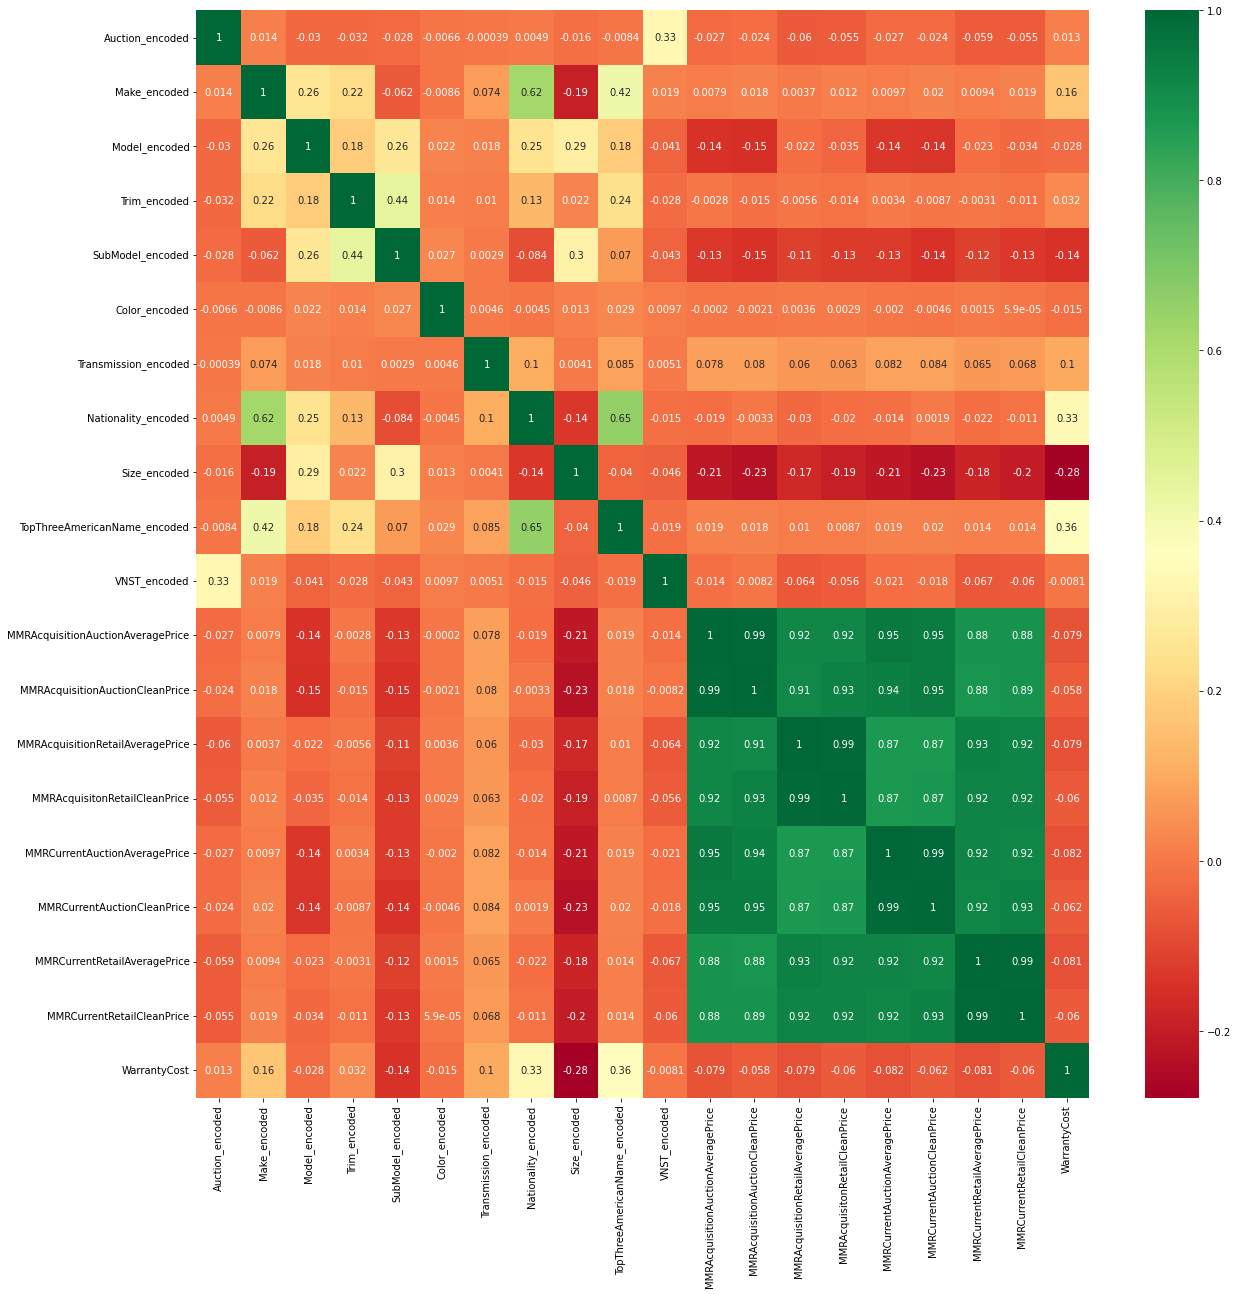

In [68]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = df_prep_balanced[features].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_prep[features][top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [69]:
# Employing  PCA to find a subset of components, which explain the variance in the data.
pca = PCA()

In [70]:
# Fit PCA with our standardized data.
pca.fit(final_dataset)

PCA()

In [71]:
# The attribute shows how much variance is explained by each of  individual components.
pca.explained_variance_ratio_

array([3.77765304e-01, 1.27315557e-01, 9.05645184e-02, 6.53917855e-02,
       5.20039636e-02, 5.01854770e-02, 4.96093065e-02, 3.94511619e-02,
       3.34209268e-02, 3.32710279e-02, 2.32599867e-02, 1.97156921e-02,
       1.36279603e-02, 1.13760365e-02, 1.00580288e-02, 1.53377858e-03,
       1.02770155e-03, 2.54855327e-04, 1.15237918e-04, 5.16934247e-05])

Text(0, 0.5, 'Cumulative Explained Variance')

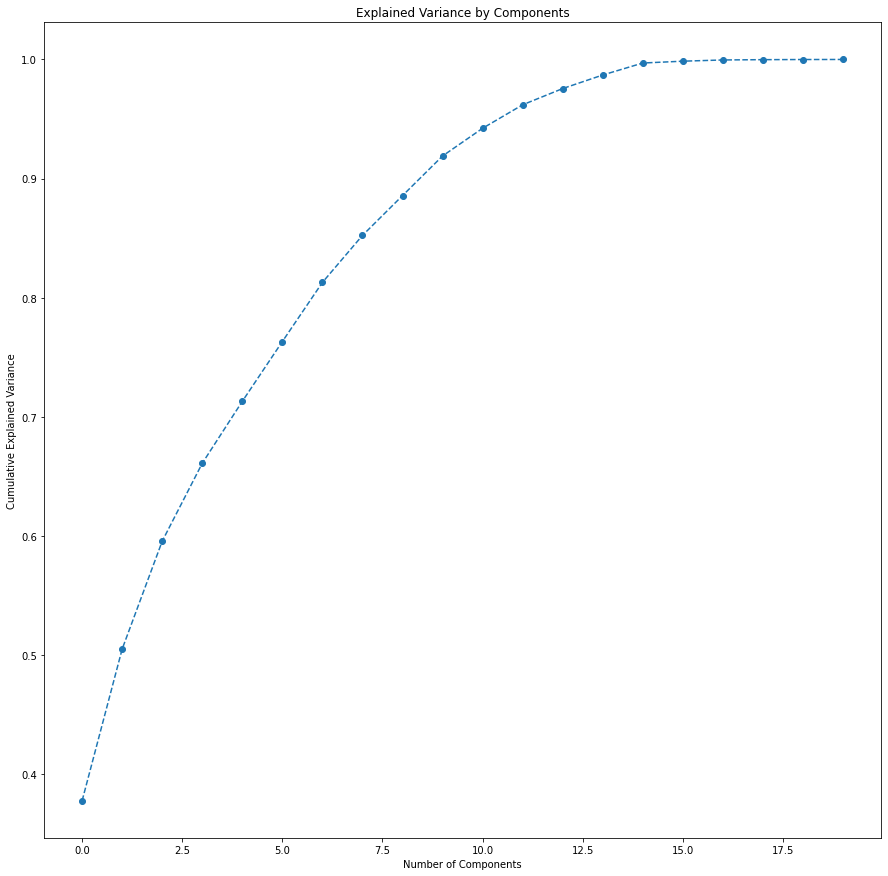

In [72]:
# Plot the cumulative variance explained by total number of components.
plt.figure(figsize = (15,15))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [73]:
model = PCA(n_components=10).fit(final_dataset)
X_pc = model.transform(final_dataset)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION 
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names =features
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSion 
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [74]:
print(df)

     0                                  1
0  PC0  MMRAcquisitionAuctionAveragePrice
1  PC1                Nationality_encoded
2  PC2                   SubModel_encoded
3  PC3                       VNST_encoded
4  PC4                       Trim_encoded
5  PC5                      Color_encoded
6  PC6               Transmission_encoded
7  PC7                       WarrantyCost
8  PC8                       VNST_encoded
9  PC9                      Model_encoded


In [75]:

MyFeatures = df_prep_balanced[features]
label = df_prep['IsBadBuy']
x_train, x_test, y_train, y_test = train_test_split(MyFeatures, label, test_size=0.25, random_state=0)

# Using Pipelines to do an Initial cross validation between classifier

In [385]:
pipeline_lr=Pipeline([('pca1',PCA(n_components=10)),
                      ('lr_classifier',LogisticRegression(random_state=0))])

In [386]:
pipeline_dt=Pipeline([('pca2',PCA(n_components=10)),
                      ('dt_classifier',DecisionTreeClassifier())])

In [387]:
pipeline_randomforest=Pipeline([('pca3',PCA(n_components=10)),
                                ('rf_classifier',RandomForestClassifier())])

In [388]:
## LEts make the list of pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_randomforest]

In [389]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [390]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest'}

# Fit the pipelines
for pipe in pipelines:
	pipe.fit(x_train, y_train)

In [391]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i],model.score(x_test,y_test)))

Logistic Regression Test Accuracy: 0.5813953488372093
Decision Tree Test Accuracy: 0.6064400715563506
RandomForest Test Accuracy: 0.6554114490161002


# Random forest classifier Hyper parameter   tuning 

In [395]:
# Create a pipeline
pipe = make_pipeline((RandomForestClassifier()))
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"randomforestclassifier": [RandomForestClassifier()],
                 "randomforestclassifier__n_estimators": [10, 100, 1000],
                 "randomforestclassifier__max_depth":[5,8,15,25,30,None],
                 "randomforestclassifier__min_samples_leaf":[1,2,5,10,15,100],
                 "randomforestclassifier__max_leaf_nodes": [2, 5,10]}]
# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(x_train,y_train)

In [397]:
best_model.score(x_test,y_test)

0.7198121645796064

In [398]:
print(best_model.best_estimator_)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=25, max_leaf_nodes=10,
                                        min_samples_leaf=5))])


In [401]:
file = open('randomforestclassifier_model.pkl', 'wb')

# dump information to that file
pickle.dump(best_model, file)